In [1]:
import random
import sys

import importlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics

import data_visualisation as dv
import data_augmentation as da

2024-05-29 22:21:48.695534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 22:21:49.179775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-29 22:21:49.179837: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-29 22:21:49.179843: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Load the Data

In [2]:
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(folds_train.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(2159, 100, 12) (2159,)
(8386,)


In [12]:
# label dist of each fold
for i in range(8):
    # size of each fold
    print(f'Fold {i} size: {X_train[folds_train == i].shape[0]}')
    # no of true labels in each fold
    print(f'Fold {i} true labels: {np.sum(Y_train[folds_train == i])}')

Fold 0 size: 1114
Fold 0 true labels: 221
Fold 1 size: 1053
Fold 1 true labels: 263
Fold 2 size: 1058
Fold 2 true labels: 295
Fold 3 size: 968
Fold 3 true labels: 335
Fold 4 size: 1019
Fold 4 true labels: 208
Fold 5 size: 1049
Fold 5 true labels: 240
Fold 6 size: 1030
Fold 6 true labels: 214
Fold 7 size: 1095
Fold 7 true labels: 338


# SMOTE

In [6]:
from imblearn.over_sampling import SMOTE

# Flatten the data
X_flattened = X_train.reshape((X_train.shape[0], -1))

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_flattened, y_resampled = smote.fit_resample(X_flattened, Y_train)

# Reshape the resampled data back to the original shape
X_resampled = X_resampled_flattened.reshape((-1, 100, 12))

no_synthetic_samples = X_resampled.shape[0] - X_train.shape[0]
print(f"Number of synthetic samples: {no_synthetic_samples}")

# generate folds (1-8) for the synthetic samples
synthetic_folds = np.random.randint(0, 8, no_synthetic_samples)
folds_resampled = np.concatenate([folds_train, synthetic_folds])

print(f"Synthetic samples fold distribution: {np.bincount(synthetic_folds)}")
folds_train_int = folds_train.astype(int)
folds_resampled_int = folds_resampled.astype(int)
print(f"original folds: {np.bincount(folds_train_int)}")
print(f"resampled folds: {np.bincount(folds_resampled_int)}")

# Verify the shapes
print("\n")
print(f"Original shape: {X_train.shape}")
print(f"Resampled shape: {X_resampled.shape}")
print(f"Original class distribution: {np.bincount(Y_train)}")
print(f"Resampled class distribution: {np.bincount(y_resampled)}")
print(f"Original folds: {folds_train.shape}")
print(f"Resampled folds: {folds_resampled.shape}")

Number of synthetic samples: 4158
Synthetic samples fold distribution: [523 533 526 517 524 528 492 515]
original folds: [1114 1053 1058  968 1019 1049 1030 1095]
resampled folds: [1637 1586 1584 1485 1543 1577 1522 1610]


Original shape: (8386, 100, 12)
Resampled shape: (12544, 100, 12)
Original class distribution: [6272 2114]
Resampled class distribution: [6272 6272]
Original folds: (8386,)
Resampled folds: (12544,)


In [13]:
# label dist of each fold
for i in range(8):
    # size of each fold
    print(f'Fold {i} size: {X_resampled[folds_resampled == i].shape[0]}')
    # no of true labels in each fold
    print(f'Fold {i} true labels: {np.sum(y_resampled[folds_resampled == i])}')

Fold 0 size: 1637
Fold 0 true labels: 744
Fold 1 size: 1586
Fold 1 true labels: 796
Fold 2 size: 1584
Fold 2 true labels: 821
Fold 3 size: 1485
Fold 3 true labels: 852
Fold 4 size: 1543
Fold 4 true labels: 732
Fold 5 size: 1577
Fold 5 true labels: 768
Fold 6 size: 1522
Fold 6 true labels: 706
Fold 7 size: 1610
Fold 7 true labels: 853


In [14]:
# save the resampled data
np.savez_compressed('data/DAT_China_1s_resampled.npz',
                    X_train=X_resampled, Y_train=y_resampled,
                    X_test=X_test, Y_test=Y_test,
                    folds_train=folds_resampled)

In [5]:
# load the resampled data
thismodule = sys.modules[__name__]
NP_DATA = 'data/DAT_China_1s_resampled.npz'
with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)
            
print(X_train.shape, Y_train.shape, folds_train.shape)
print(X_test.shape, Y_test.shape)

(12544, 100, 12) (12544,) (12544,)
(2159, 100, 12) (2159,)


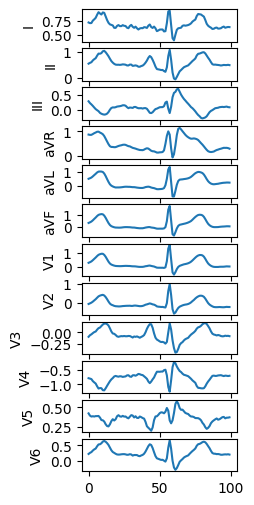

In [14]:
# visualise the data

# get train data where label is 1
X_train_positive = X_train[Y_train]

# plot a random sample
random_sample = random.choice(X_train_positive)
dv.plot_12_lead_ecg(random_sample)

# Deep SMOTE

In [12]:
def encoder(inputs, latent_dim):
    # 100 x 12
    X = layers.Conv1D(24, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv1')(inputs)
    # 96 x 24
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 48 x 32
    X = layers.Conv1D(48, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv2')(X)
    # 44 x 48
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 22 x 48
    X = layers.Conv1D(64, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='conv3')(X)
    # 18 x 64
    X = layers.MaxPooling1D(2)(X)
    X = layers.Dropout(0.2)(X)
    # 9 x 64
    X = layers.Flatten()(X)
    # 1152
    X = layers.Dense(latent_dim, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense-encode')(X)
    # latent_dim
    return X

def decoder(latent_rep, latent_dim):
    X = layers.Dense(9*64, activation=keras.layers.LeakyReLU(alpha=0.3), name='dense-decode')(latent_rep)
    # 1152
    X = layers.Reshape((9, 64))(X)
    # 9 x 64
    X = layers.UpSampling1D(2)(X)
    # 18 x 64
    X = layers.Conv1DTranspose(48, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='upconv1')(X)
    # 22 x 48
    X = layers.UpSampling1D(2)(X)
    # 44 x 48
    X = layers.Conv1DTranspose(24, 5, activation=keras.layers.LeakyReLU(alpha=0.3), padding='valid', name='upconv2')(X)
    # 48 x 24
    X = layers.UpSampling1D(2)(X)
    # 96 x 24
    X = layers.Conv1DTranspose(12, 5, activation='linear', padding='valid', name='upconv3')(X)
    # 100 x 12
    return X

def make_model(inputs, latent_dim):
    latent_rep = encoder(inputs, latent_dim)
    X = decoder(latent_rep, latent_dim)
    return keras.Model(inputs=inputs, outputs=X)

inputs = keras.Input(shape=(100, 12))
model = make_model(inputs, 256)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer='adam', loss='mse')
model.summary()

model.load_weights('temp/ae2.h5', by_name=True)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1 (Conv1D)              (None, 96, 24)            1464      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 48, 24)           0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 48, 24)            0         
                                                                 
 conv2 (Conv1D)              (None, 44, 48)            5808      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 22, 48)           0         
 1D)                                                       

In [20]:
# Split the data into training and validation sets
validation_split = 0.2
num_val_samples = int(validation_split * len(X_train))
num_train_samples = len(X_train) - num_val_samples

X_train_data = X_train[:num_train_samples]
X_val_data = X_train[num_train_samples:]

# Create tf.data.Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_data, X_train_data))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_data, X_val_data))

# Shuffle and batch the datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [21]:
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


2024-05-29 20:34:51.593658: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x33025d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-29 20:34:51.593677: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-29 20:34:51.597518: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-29 20:34:51.672190: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


210/210 [==============================] - 3s 7ms/step - loss: 0.2885 - val_loss: 1.1647
Epoch 2/10
210/210 [==============================] - 1s 6ms/step - loss: 0.1529 - val_loss: 1.3693
Epoch 3/10
210/210 [==============================] - 1s 5ms/step - loss: 0.2687 - val_loss: 1.4568
Epoch 4/10
210/210 [==============================] - 1s 6ms/step - loss: 0.4297 - val_loss: 1.5081
Epoch 5/10
210/210 [==============================] - 1s 6ms/step - loss: 0.3090 - val_loss: 1.8128
Epoch 6/10
210/210 [==============================] - 1s 6ms/step - loss: 0.2173 - val_loss: 2.1166
Epoch 7/10
210/210 [==============================] - 1s 6ms/step - loss: 0.2926 - val_loss: 1.7629
Epoch 8/10
210/210 [==============================] - 1s 6ms/step - loss: 0.2102 - val_loss: 1.5987
Epoch 9/10
210/210 [==============================] - 1s 6ms/step - loss: 0.2136 - val_loss: 1.4306
Epoch 10/10
210/210 [==============================] - 1s 6ms/step - loss: 0.3753 - val_loss: 1.9000


(100, 12)
(None, 100, 12)
1/1 [==============================] - 0s 11ms/step


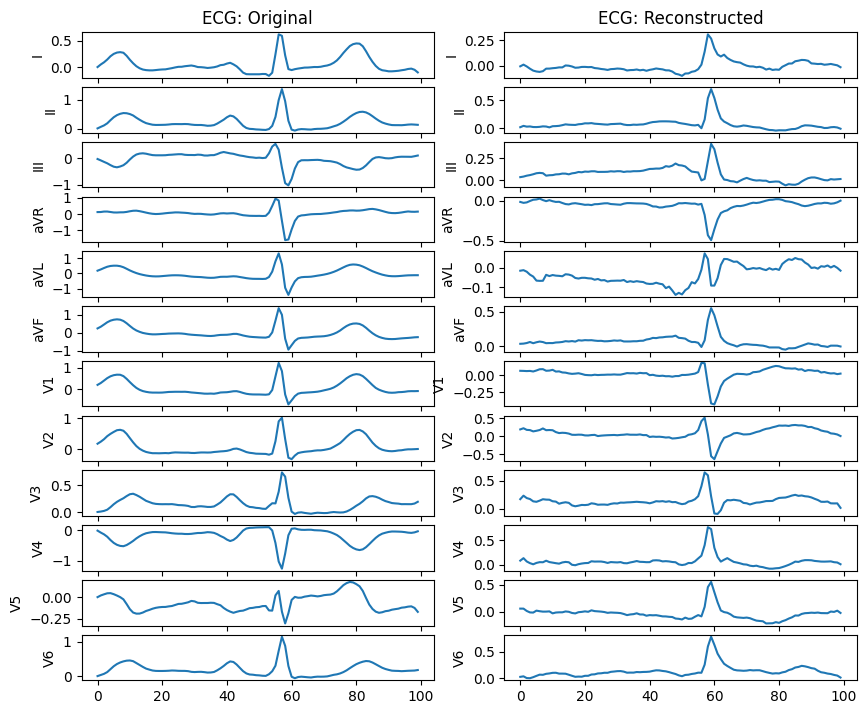

In [19]:
random_sample = random.choice(X_test)
print(random_sample.shape)
print(inputs.shape)

reconstructed_sample = model.predict(random_sample[None, ...])[0]

dv.plot_12_lead_ecgs([random_sample, reconstructed_sample], ['Original', 'Reconstructed'])
